<a href="https://colab.research.google.com/github/arvindsuresh-math/Fall-2025-Team-Big-Data/blob/main/notebooks/modeling_oct_21-nyc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook outlines a deep learning approach to predict Airbnb listing prices in New York City. The primary goal is to create a highly interpretable model that explains *why* a listing has a certain price relative to its local market.

The model is architected as a series of parallel sub-networks, each specializing in a different aspect of a listing: location, size, quality, amenities, description, and seasonality. Instead of predicting the absolute price, this model predicts the listing's price **deviation** from the average price in its neighborhood. This is a multiplicative model, where each sub-network learns a factor that scales the price up or down based on its features. The final layers of the text embedding models are fine-tuned to adapt their representations for this specific price prediction task.

#### **0. Setup and Installations**

In [1]:
# --- Hugging Face Authentication (using Colab Secrets) ---
from google.colab import userdata
from huggingface_hub import login
print("Attempting Hugging Face login...")
try:
    HF_TOKEN = userdata.get('HF_TOKEN')
    login(token=HF_TOKEN)
    print("Hugging Face login successful.")
except Exception as e:
    print(f"Could not log in. Please ensure 'HF_TOKEN' is a valid secret. Error: {e}")

Attempting Hugging Face login...
Hugging Face login successful.


In [2]:
# --- Mount Google Drive ---
from google.colab import drive
print("Mounting Google Drive...")
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Could not mount Google Drive. Error: {e}")

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.


In [3]:
# --- Install Dependencies ---
!pip install pandas
!pip install pyarrow
!pip install sentence-transformers
!pip install scikit-learn
!pip install torch
!pip install tqdm
!pip install transformers
!pip install matplotlib
!pip install seaborn

### **1. Configuration and Helper Functions**

This cell defines a central configuration dictionary for all hyperparameters and a seeding function to ensure reproducible results. The model's architecture, including the size and number of hidden layers for each sub-network, is defined here for easy experimentation.

In [4]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [5]:
# --- Seeding function for reproducibility ---
def set_seed(seed: int):
    """Sets random seeds for numpy and torch for reproducible results."""
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"All random seeds set to {seed}.")

In [6]:
# --- Central Configuration Dictionary ---
config = {
    # --- Data and Environment ---
    "CITY": "nyc",
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "DRIVE_SAVE_PATH": "/content/drive/MyDrive/Colab_Notebooks/Airbnb_Project/",
    "TEXT_MODEL_NAME": 'BAAI/bge-small-en-v1.5',
    "VAL_SIZE": 0.2,
    "SEED": 42,

    # --- Model Training ---
    "BATCH_SIZE": 256,
    "VALIDATION_BATCH_SIZE": 512,
    "LEARNING_RATE": 1e-3,
    "TRANSFORMER_LEARNING_RATE": 1e-5, # Separate, lower LR for fine-tuning
    "N_EPOCHS": 50,

    # --- Model Architecture ---
    "HIDDEN_LAYERS_LOCATION": [32, 16],
    "HIDDEN_LAYERS_SIZE_CAPACITY": [32, 16],
    "HIDDEN_LAYERS_QUALITY": [32, 16],
    "HIDDEN_LAYERS_AMENITIES": [64, 32],
    "HIDDEN_LAYERS_DESCRIPTION": [64, 32],
    "HIDDEN_LAYERS_SEASONALITY": [16],

    # --- Early Stopping & Scheduler ---
    "EARLY_STOPPING_PATIENCE": 10,
    "EARLY_STOPPING_MIN_DELTA": 0.001, # 0.1% MAPE
    "SCHEDULER_PATIENCE": 2,
    "SCHEDULER_FACTOR": 0.5,
}

### **2. Data Loading and Splitting**

This function loads the dataset, performs a stratified split to ensure the training and validation sets are representative, and calculates the mean log-price for each neighborhood from the training data. This neighborhood-level baseline is crucial for the model's relative prediction task.

In [7]:
def load_and_split_data(config: dict):
    """
    Loads the dataset, calculates neighborhood-level average log-prices from the
    training set, and performs a stratified split.

    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: The training data.
            - pd.DataFrame: The validation data.
            - dict: A mapping from neighborhood to its mean log-price.
    """
    dataset_filename = f"{config['CITY']}_dataset_oct_20.parquet"
    dataset_path = f"./{dataset_filename}"
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"'{dataset_filename}' not found. Please upload the file.")

    print(f"Loading dataset from: {dataset_path}")
    df = pd.read_parquet(dataset_path)
    df = df[df["price"] > 0].copy()

    # Stratify by neighborhood, month, and price quantiles for a representative split
    df['price_bin'] = pd.qcut(df['price'], q=10, labels=False, duplicates='drop')
    stratify_key = (df['neighbourhood_cleansed'].astype(str) + '_' +
                    df['month'].astype(str) + '_' + df['price_bin'].astype(str))

    strata_counts = stratify_key.value_counts()
    valid_strata = strata_counts[strata_counts >= 2].index
    df_filtered = df[stratify_key.isin(valid_strata)].copy()

    train_indices, val_indices = train_test_split(
        df_filtered.index,
        test_size=config['VAL_SIZE'],
        random_state=config['SEED'],
        stratify=stratify_key[df_filtered.index]
    )
    train_df = df_filtered.loc[train_indices].reset_index(drop=True)
    val_df = df_filtered.loc[val_indices].reset_index(drop=True)

    # Calculate neighborhood means using ONLY the training data to prevent leakage
    neighborhood_log_means = np.log1p(train_df.groupby('neighbourhood_cleansed')['price'].mean()).to_dict()

    print(f"Split complete. Training: {len(train_df):,}, Validation: {len(val_df):,}")
    return train_df, val_df, neighborhood_log_means

### **3. Feature Processing**

The `FeatureProcessor` class is responsible for converting raw data into numerical tensors for the model. It handles categorical feature encoding, numerical feature scaling, and computes the new relative target variable: the difference between a listing's log-price and its neighborhood's average log-price.

In [8]:
class FeatureProcessor:
    """
    Prepares raw DataFrame columns into numerical features for the model.
    The fit/transform pattern prevents data leakage from the validation set.
    """
    def __init__(self, embedding_dim_geo: int = 32):
        self.vocabs, self.scalers = {}, {}
        self.embedding_dim_geo = embedding_dim_geo
        self.categorical_cols = ["property_type", "room_type"]
        self.numerical_cols = ["accommodates", "review_scores_rating", "review_scores_cleanliness",
                               "review_scores_checkin", "review_scores_communication",
                               "review_scores_location", "review_scores_value",
                               "bedrooms", "beds", "bathrooms"]
        self.log_transform_cols = ["total_reviews"]

    def fit(self, df: pd.DataFrame):
        """Fits scalers and vocabularies based on the training data."""
        print("Fitting FeatureProcessor...")
        for col in self.categorical_cols:
            self.vocabs[col] = {val: i for i, val in enumerate(["<UNK>"] + sorted(df[col].unique()))}

        for col in self.numerical_cols + self.log_transform_cols:
            vals = df[col].astype(float)
            vals = np.log1p(vals) if col in self.log_transform_cols else vals
            self.scalers[col] = {'mean': vals.mean(), 'std': vals.std()}
        print("Fit complete.")

    def transform(self, df: pd.DataFrame, neighborhood_log_means: dict) -> dict:
        """Transforms a DataFrame into a dictionary of feature tensors."""
        df = df.copy()
        # --- Target Variable Transformation ---
        df['neighborhood_log_mean'] = df['neighbourhood_cleansed'].map(neighborhood_log_means)
        # Handle neighborhoods present in validation but not training
        global_mean = sum(neighborhood_log_means.values()) / len(neighborhood_log_means)
        df['neighborhood_log_mean'].fillna(global_mean, inplace=True)

        target_log_deviation = (np.log1p(df["price"]) - df['neighborhood_log_mean']).to_numpy(dtype=np.float32)

        # --- Feature Engineering ---
        # Geospatial positional encoding
        half_dim = self.embedding_dim_geo // 2
        lat = df["latitude"].to_numpy(dtype=np.float32)
        lon = df["longitude"].to_numpy(dtype=np.float32)
        def pe(arr, max_val, d):
            pos = (arr / max_val) * 10000.0
            idx = np.arange(0, d, 2, dtype=np.float32)
            div = np.exp(-(np.log(10000.0) / d) * idx)
            s, c = np.sin(pos[:, None] * div[None, :]), np.cos(pos[:, None] * div[None, :])
            out = np.empty((arr.shape[0], d), dtype=np.float32)
            out[:, 0::2], out[:, 1::2] = s, c
            return out
        geo_position = np.hstack([pe(lat, 90.0, half_dim), pe(lon, 180.0, half_dim)])

        # Size & Capacity features
        size_features = {
            "property_type": df["property_type"].map(self.vocabs["property_type"]).fillna(0).astype(np.int64),
            "room_type": df["room_type"].map(self.vocabs["room_type"]).fillna(0).astype(np.int64)
        }
        for col in ["accommodates", "bedrooms", "beds", "bathrooms"]:
            x = df[col].astype(float)
            size_features[col] = ((x - self.scalers[col]["mean"]) / self.scalers[col]["std"]).astype(np.float32)

        # Quality & Reputation features
        quality_features = {}
        quality_num_cols = set(self.numerical_cols) - set(size_features.keys()) - set(self.categorical_cols)
        for col in quality_num_cols:
            x = df[col].astype(float)
            quality_features[col] = ((x - self.scalers[col]["mean"]) / self.scalers[col]["std"]).astype(np.float32)

        tr_log = np.log1p(df["total_reviews"].astype(float))
        quality_features["total_reviews"] = (tr_log - self.scalers["total_reviews"]["mean"]) / self.scalers["total_reviews"]["std"]
        quality_features["host_is_superhost"] = df["host_is_superhost"].astype(np.float32)

        # Seasonality (cyclical) features
        month = df["month"].to_numpy(np.float32)
        season_cyc = np.stack([np.sin(2 * np.pi * month / 12), np.cos(2 * np.pi * month / 12)], axis=1)

        return {
            "location": {"geo_position": geo_position},
            "size_capacity": {k: v.to_numpy() for k, v in size_features.items()},
            "quality": {k: v.to_numpy() for k, v in quality_features.items()},
            "amenities_text": df["amenities"].tolist(),
            "description_text": df["description"].tolist(),
            "seasonality": {"cyclical": season_cyc},
            "target_price": df["price"].to_numpy(dtype=np.float32),
            "target_log_deviation": target_log_deviation,
            "neighborhood_log_mean": df['neighborhood_log_mean'].to_numpy(dtype=np.float32),
        }

### **4. PyTorch Dataset and DataLoader**

The `AirbnbPriceDataset` class organizes the processed features for PyTorch, tokenizing text on-the-fly. The `create_dataloaders` function then wraps this dataset in `DataLoader` objects, which handle batching, shuffling, and multi-process data loading.

In [9]:
class AirbnbPriceDataset(Dataset):
    """PyTorch Dataset to handle tokenization and feature collation."""
    def __init__(self, features: dict, tokenizer):
        self.features = features
        self.tokenizer = tokenizer
        self.n_samples = len(features['target_price'])

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index: int) -> dict:
        item = {
            'loc_geo_position': torch.tensor(self.features['location']['geo_position'][index], dtype=torch.float32),
            'season_cyclical': torch.tensor(self.features['seasonality']['cyclical'][index], dtype=torch.float32),
            'target_price': torch.tensor(self.features['target_price'][index], dtype=torch.float32),
            'target_log_deviation': torch.tensor(self.features['target_log_deviation'][index], dtype=torch.float32),
            'neighborhood_log_mean': torch.tensor(self.features['neighborhood_log_mean'][index], dtype=torch.float32),
        }
        for k, v in self.features['size_capacity'].items():
            dtype = torch.long if k in ['property_type', 'room_type'] else torch.float32
            item[f'size_{k}'] = torch.tensor(v[index], dtype=dtype)
        for k, v in self.features['quality'].items():
            item[f'qual_{k}'] = torch.tensor(v[index], dtype=dtype)

        # On-the-fly tokenization
        item['amenities_tokens'] = self.tokenizer(
            self.features['amenities_text'][index],
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )
        item['description_tokens'] = self.tokenizer(
            self.features['description_text'][index],
            padding='max_length',
            truncation=True,
            max_length=256,
            return_tensors="pt"
        )
        return item

def create_dataloaders(train_features: dict, val_features: dict, config: dict):
    """Initializes and returns the training and validation DataLoaders."""
    tokenizer = AutoTokenizer.from_pretrained(config['TEXT_MODEL_NAME'], use_fast=True)
    train_dataset = AirbnbPriceDataset(train_features, tokenizer)
    val_dataset = AirbnbPriceDataset(val_features, tokenizer)

    train_loader = DataLoader(
        train_dataset,
        batch_size=config['BATCH_SIZE'],
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config['VALIDATION_BATCH_SIZE'],
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    print("DataLoaders created.")
    return train_loader, val_loader

### **5. Model Architecture**

The `AdditiveAxisModel` defines the neural network. It dynamically constructs six parallel multi-layer perceptrons (MLPs) based on the configuration. The final layer of the pre-trained text transformer is unfrozen to allow for fine-tuning. The model includes methods to return not only the final prediction but also the intermediate hidden states and the price contribution of each axis, enabling deep interpretability.

In [10]:
class AdditiveAxisModel(nn.Module):
    """
    A multi-axis neural network that predicts price deviation from a baseline.

    The model is composed of six sub-networks, each processing a different
    modality of the listing data. The final output is the sum of the outputs
    from each sub-network, representing the predicted log-price deviation.
    """
    def __init__(self, processor: FeatureProcessor, config: dict):
        super().__init__()
        self.device = config['DEVICE']

        # --- Embeddings for Categorical Features ---
        self.embed_property_type = nn.Embedding(len(processor.vocabs['property_type']), 8)
        self.embed_room_type = nn.Embedding(len(processor.vocabs['room_type']), 4)

        # --- Text Transformer (with last layer unfrozen for fine-tuning) ---
        self.text_transformer = SentenceTransformer(config['TEXT_MODEL_NAME'], device=self.device)
        for param in self.text_transformer.parameters():
            param.requires_grad = False
        # Unfreeze the final transformer layer
        for param in self.text_transformer[0].auto_model.encoder.layer[-1].parameters():
            param.requires_grad = True

        # --- Helper to Dynamically Create MLP Sub-networks ---
        def _create_mlp(in_features, layer_sizes):
            layers = []
            for size in layer_sizes:
                layers.append(nn.Linear(in_features, size))
                layers.append(nn.ReLU())
                in_features = size
            return nn.Sequential(*layers)

        # --- Dynamically create sub-network "bodies" and "heads" ---
        text_embed_dim = self.text_transformer.get_sentence_embedding_dimension()
        self.loc_subnet_body = _create_mlp(32, config['HIDDEN_LAYERS_LOCATION'])
        self.size_subnet_body = _create_mlp(16, config['HIDDEN_LAYERS_SIZE_CAPACITY'])
        self.qual_subnet_body = _create_mlp(8, config['HIDDEN_LAYERS_QUALITY'])
        self.amenities_subnet_body = _create_mlp(text_embed_dim, config['HIDDEN_LAYERS_AMENITIES'])
        self.desc_subnet_body = _create_mlp(text_embed_dim, config['HIDDEN_LAYERS_DESCRIPTION'])
        self.season_subnet_body = _create_mlp(2, config['HIDDEN_LAYERS_SEASONALITY'])

        self.loc_subnet_head = nn.Linear(config['HIDDEN_LAYERS_LOCATION'][-1], 1)
        self.size_subnet_head = nn.Linear(config['HIDDEN_LAYERS_SIZE_CAPACITY'][-1], 1)
        self.qual_subnet_head = nn.Linear(config['HIDDEN_LAYERS_QUALITY'][-1], 1)
        self.amenities_subnet_head = nn.Linear(config['HIDDEN_LAYERS_AMENITIES'][-1], 1)
        self.desc_subnet_head = nn.Linear(config['HIDDEN_LAYERS_DESCRIPTION'][-1], 1)
        self.season_subnet_head = nn.Linear(config['HIDDEN_LAYERS_SEASONALITY'][-1], 1)

        self.to(self.device)

    def forward_with_hidden_states(self, batch: dict) -> dict:
        """Performs a full forward pass, returning predictions, contributions, and hidden states."""
        # --- Prepare Inputs for each Axis ---
        loc_input = batch['loc_geo_position']
        size_input = torch.cat(
            [self.embed_property_type(batch['size_property_type']),
             self.embed_room_type(batch['size_room_type']),
             batch['size_accommodates'].unsqueeze(1),
             batch['size_bedrooms'].unsqueeze(1),
             batch['size_beds'].unsqueeze(1),
             batch['size_bathrooms'].unsqueeze(1)
             ], dim=1
        )
        qual_cols = ["review_scores_rating", "review_scores_cleanliness", "review_scores_checkin",
                     "review_scores_communication", "review_scores_location", "review_scores_value",
                     "total_reviews", "host_is_superhost"]
        qual_input = torch.cat([batch[f'qual_{c}'].unsqueeze(1) for c in qual_cols], dim=1)

        amenities_tokens = {k: v.squeeze(1) for k, v in batch['amenities_tokens'].items()}
        desc_tokens = {k: v.squeeze(1) for k, v in batch['description_tokens'].items()}
        amenities_embed = self.text_transformer(amenities_tokens)['sentence_embedding']
        desc_embed = self.text_transformer(desc_tokens)['sentence_embedding']

        # --- Process through Sub-network Bodies (to get hidden states) ---
        h_loc = self.loc_subnet_body(loc_input)
        h_size = self.size_subnet_body(size_input)
        h_qual = self.qual_subnet_body(qual_input)
        h_amenities = self.amenities_subnet_body(amenities_embed)
        h_desc = self.desc_subnet_body(desc_embed)
        h_season = self.season_subnet_body(batch['season_cyclical'])

        # --- Process through Sub-network Heads (to get price contributions) ---
        p_loc = self.loc_subnet_head(h_loc)
        p_size = self.size_subnet_head(h_size)
        p_qual = self.qual_subnet_head(h_qual)
        p_amenities = self.amenities_subnet_head(h_amenities)
        p_desc = self.desc_subnet_head(h_desc)
        p_season = self.season_subnet_head(h_season)

        predicted_log_deviation = (p_loc + p_size + p_qual + p_amenities + p_desc + p_season)

        return {
            'predicted_log_deviation': predicted_log_deviation.squeeze(-1),
            'p_location': p_loc.squeeze(-1),
            'p_size_capacity': p_size.squeeze(-1),
            'p_quality': p_qual.squeeze(-1),
            'p_amenities': p_amenities.squeeze(-1),
            'p_description': p_desc.squeeze(-1),
            'p_seasonality': p_season.squeeze(-1),
            'h_location': h_loc,
            'h_size_capacity': h_size,
            'h_quality': h_qual,
            'h_amenities': h_amenities,
            'h_description': h_desc,
            'h_seasonality': h_season,
        }

    def forward_with_price(self, batch: dict) -> dict:
        """Calls the base method and returns only the price decomposition components."""
        all_outputs = self.forward_with_hidden_states(batch)
        return {k: v for k, v in all_outputs.items() if not k.startswith('h_')}

    def forward(self, batch: dict) -> torch.Tensor:
        """The standard forward pass for training, returning only the final prediction tensor."""
        return self.forward_with_hidden_states(batch)['predicted_log_deviation']

### **6. Training and Evaluation Functions**

The `evaluate_model` function calculates performance on the validation set. It reconstructs the absolute predicted price to compute the Mean Absolute Percentage Error (MAPE), which is used for early stopping. The `train_model` function contains the main training loop, including optimization, gradient scaling, and logging.

In [11]:
def evaluate_model(model, data_loader, device):
    """Calculates validation loss and MAPE."""
    model.eval()
    total_loss, total_mape = 0.0, 0.0
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Validating", leave=False):
            # Move all tensors in the batch to the designated device
            for k, v in batch.items():
                if isinstance(v, torch.Tensor): batch[k] = v.to(device)
                else: batch[k] = {sk: sv.to(device) for sk, sv in v.items()}

            targets_price = batch['target_price']
            targets_log_dev = batch['target_log_deviation']

            with torch.amp.autocast(device_type=device, dtype=torch.float16, enabled=(device=="cuda")):
                preds_log_dev = model(batch)
                loss = torch.mean((preds_log_dev - targets_log_dev).float().pow(2)) # MSE on log deviation

                # Reconstruct price for MAPE calculation
                predicted_log_price = preds_log_dev + batch['neighborhood_log_mean']
                price_preds = torch.expm1(predicted_log_price)
                mape = (torch.abs(price_preds - targets_price) / (targets_price + 1e-6)).mean()

            total_loss += loss.item()
            total_mape += mape.item()
    return total_loss / len(data_loader), total_mape / len(data_loader)

def train_model(model, train_loader, val_loader, optimizer, scheduler, config):
    """Main function to train the model, with early stopping based on validation MAPE."""
    print("\n--- Starting Model Training ---")
    history, best_val_mape = [], float('inf')
    best_model_state, patience_counter = None, 0
    scaler = torch.amp.GradScaler(enabled=(config['DEVICE'] == "cuda"))
    start_time = time.time()

    header = f"{'Epoch':>5} | {'Time':>8} | {'Train RMSE':>12} | {'Val RMSE':>10} | {'Val MAPE (%)':>12} | {'Patience':>8}"
    print(header); print("-" * len(header))

    for epoch in range(config['N_EPOCHS']):
        model.train()
        train_loss_epoch = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['N_EPOCHS']}", leave=False):
            for k, v in batch.items():
                if isinstance(v, torch.Tensor): batch[k] = v.to(config['DEVICE'])
                else: batch[k] = {sk: sv.to(config['DEVICE']) for sk, sv in v.items()}

            with torch.amp.autocast(device_type=config['DEVICE'], dtype=torch.float16, enabled=(config['DEVICE']=="cuda")):
                preds_log_dev = model(batch)
                loss = torch.mean((preds_log_dev - batch["target_log_deviation"]).float().pow(2))

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss_epoch += loss.item()

        val_mse, val_mape = evaluate_model(model, val_loader, config['DEVICE'])
        train_rmse, val_rmse = np.sqrt(train_loss_epoch / len(train_loader)), np.sqrt(val_mse)
        elapsed_time = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))

        if val_mape < best_val_mape - config['EARLY_STOPPING_MIN_DELTA']:
            best_val_mape, patience_counter = val_mape, 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        print(f"{epoch+1:>5} | {elapsed_time:>8} | {train_rmse:>12.4f} | {val_rmse:>10.4f} | {val_mape*100:>12.2f} | {patience_counter:>8}")
        history.append({'epoch': epoch, 'train_rmse': train_rmse, 'val_rmse': val_rmse, 'val_mape': val_mape})
        scheduler.step(val_mape)

        if patience_counter >= config['EARLY_STOPPING_PATIENCE']:
            print(f"--- Early Stopping Triggered (MAPE did not improve) ---"); break

    print("\n--- Training Complete ---")
    if best_model_state: model.load_state_dict(best_model_state)
    return model, pd.DataFrame(history)

### **7. Inference, Saving, and Analysis**

These functions are for post-training tasks. `run_inference_with_details` gets the full price decomposition for the validation set. `save_artifacts_simple` saves the trained model and processor. `analyze_results` provides a detailed performance summary, including visualizations and an analysis of the multiplicative contributions of each model axis.

In [18]:
def run_inference_with_details(model, data_loader, device):
    """
    Runs inference and returns the full decomposition, including hidden states,
    for each listing.
    """
    model.eval()
    outputs = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Running Inference with Details", leave=False):
            for k, v in batch.items():
                if isinstance(v, torch.Tensor): batch[k] = v.to(device)
                else: batch[k] = {sk: sv.to(device) for sk, sv in v.items()}

            # FIX: Call forward_with_hidden_states to get ALL outputs
            batch_outputs = model.forward_with_hidden_states(batch)

            # Add neighborhood mean to reconstruct full log price later
            batch_outputs['neighborhood_log_mean'] = batch['neighborhood_log_mean']
            outputs.append({k: v.cpu() for k, v in batch_outputs.items()})

    # This part remains the same, but will now process 'h_' tensors as well
    final_outputs = {key: torch.cat([o[key] for o in outputs]).numpy() for key in outputs[0].keys()}

    # Reconstruct final predicted price
    predicted_log = final_outputs['predicted_log_deviation'] + final_outputs['neighborhood_log_mean']
    final_outputs['predicted_price'] = np.expm1(predicted_log)
    return final_outputs

def save_artifacts_simple(model, processor, config):
    """Saves the model, feature processor, and config to a file."""
    timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
    filename = f"{config['CITY']}_model_artifacts_{timestamp}.pt"
    save_path = os.path.join(config['DRIVE_SAVE_PATH'], filename)
    os.makedirs(config['DRIVE_SAVE_PATH'], exist_ok=True)

    torch.save({
        'model_state_dict': model.state_dict(),
        'feature_processor': processor,
        'config': config
    }, save_path)
    print(f"\nArtifacts saved to {save_path}")

def analyze_results(df_with_preds):
    """Visualizes model performance and interprets the multiplicative decomposition."""
    mae = (df_with_preds['predicted_price'] - df_with_preds['price']).abs().mean()
    print(f"\n--- Final Performance (Validation Set) ---\nMean Absolute Error: ${mae:.2f}")

    plt.figure(figsize=(8, 8))
    sns.scatterplot(x='price', y='predicted_price', data=df_with_preds.sample(min(len(df_with_preds), 2000)), alpha=0.5)
    plt.plot([0, df_with_preds['price'].max()], [0, df_with_preds['price'].max()], 'r--')
    plt.title("True vs. Predicted Prices"); plt.xlabel("True Price ($)"); plt.ylabel("Predicted Price ($)"); plt.grid(True); plt.show()

    df_analysis = df_with_preds.copy()
    # FIX: The denominator for MAPE must be the target variable, 'price'.
    df_analysis['mape'] = (df_analysis['predicted_price'] - df_analysis['price']).abs() / (df_analysis['price'] + 1e-6) * 100
    bins = np.arange(0, min(200, df_analysis['price'].max()) + 10, 10)
    df_analysis['price_bin'] = pd.cut(df_analysis['price'], bins=bins, right=False)
    binned_mape = df_analysis.groupby('price_bin', observed=False)['mape'].mean().reset_index()

    plt.figure(figsize=(12, 6))
    sns.barplot(x='price_bin', y='mape', data=binned_mape, palette='viridis'); plt.title("MAPE by Price Bracket")
    plt.xlabel("Price Bracket ($)"); plt.ylabel("MAPE (%)"); plt.xticks(rotation=45); plt.grid(axis='y'); plt.show()

    # --- Analyze Multiplicative Decomposition ---
    print("\n--- Analysis of Multiplicative Decomposition ---")
    p_cols = [col for col in df_with_preds.columns if col.startswith('p_')]
    decomposition_stats = df_with_preds[p_cols].mean().sort_values(ascending=False)
    print("Average Additive Contribution of Each Component to the Log-Price Deviation:")
    print(decomposition_stats)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=decomposition_stats.values, y=decomposition_stats.index, orient='h')
    plt.title("Average Contribution to Log-Price Deviation by Subnet")
    plt.xlabel("Average Contribution to Log-Price Deviation"); plt.ylabel("Model Component"); plt.grid(axis='x'); plt.show()

### **8. Main Orchestration and Execution**

The `main` function orchestrates the entire workflow, from data loading to model training, inference, and analysis. It correctly sets up the optimizer with differential learning rates for the main model and the transformer's fine-tuned layer.

In [13]:
def main(config: dict):
    """Orchestrates the end-to-end model training and evaluation pipeline."""
    train_df, val_df, neighborhood_log_means = load_and_split_data(config)

    processor = FeatureProcessor()
    processor.fit(train_df)
    train_features = processor.transform(train_df, neighborhood_log_means)
    val_features = processor.transform(val_df, neighborhood_log_means)
    train_loader, val_loader = create_dataloaders(train_features, val_features, config)

    model = AdditiveAxisModel(processor, config)

    # --- Optimizer with Differential Learning Rates ---
    transformer_params = model.text_transformer.parameters()
    other_params = [p for n, p in model.named_parameters() if 'text_transformer' not in n]
    optimizer = optim.AdamW([
        {'params': other_params, 'lr': config['LEARNING_RATE']},
        {'params': transformer_params, 'lr': config['TRANSFORMER_LEARNING_RATE']}
    ])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=config['SCHEDULER_FACTOR'], patience=config['SCHEDULER_PATIENCE'])

    trained_model, history = train_model(model, train_loader, val_loader, optimizer, scheduler, config)
    details_outputs = run_inference_with_details(trained_model, val_loader, config['DEVICE'])
    val_df_with_details = val_df.copy()
    for key, value in details_outputs.items():
        val_df_with_details[key] = list(value)

    save_artifacts_simple(trained_model, processor, config)
    analyze_results(val_df_with_details)

    return {
        'model': trained_model, 'processor': processor,
        'val_df_with_details': val_df_with_details,
        'history': history, 'config': config
    }

All random seeds set to 42.
Loading dataset from: ./nyc_dataset_oct_20.parquet
Split complete. Training: 98,388, Validation: 24,598
Fitting FeatureProcessor...
Fit complete.


/tmp/ipython-input-3102782108.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['neighborhood_log_mean'].fillna(global_mean, inplace=True)
/tmp/ipython-input-3102782108.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

DataLoaders created.

--- Starting Model Training ---
Epoch |     Time |   Train RMSE |   Val RMSE | Val MAPE (%) | Patience
----------------------------------------------------------------------


Epoch 1/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

    1 | 00:01:41 |       0.3891 |     0.3351 |        27.47 |        0


Epoch 2/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

    2 | 00:03:20 |       0.3259 |     0.3051 |        24.56 |        0


Epoch 3/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

    3 | 00:05:00 |       0.3055 |     0.2839 |        23.44 |        0


Epoch 4/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

    4 | 00:06:40 |       0.2895 |     0.2682 |        22.41 |        0


Epoch 5/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

    5 | 00:08:20 |       0.2765 |     0.2550 |        20.13 |        0


Epoch 6/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

    6 | 00:09:59 |       0.2670 |     0.2457 |        19.27 |        0


Epoch 7/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

    7 | 00:11:39 |       0.2604 |     0.2375 |        18.70 |        0


Epoch 8/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

    8 | 00:13:19 |       0.2540 |     0.2311 |        18.05 |        0


Epoch 9/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

    9 | 00:14:58 |       0.2491 |     0.2257 |        17.96 |        1


Epoch 10/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   10 | 00:16:38 |       0.2447 |     0.2210 |        17.48 |        0


Epoch 11/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   11 | 00:18:17 |       0.2419 |     0.2315 |        17.05 |        0


Epoch 12/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   12 | 00:19:58 |       0.2382 |     0.2196 |        18.05 |        1


Epoch 13/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   13 | 00:21:37 |       0.2360 |     0.2114 |        16.70 |        0


Epoch 14/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   14 | 00:23:17 |       0.2337 |     0.2120 |        16.44 |        0


Epoch 15/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   15 | 00:24:57 |       0.2313 |     0.2113 |        17.14 |        1


Epoch 16/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   16 | 00:26:36 |       0.2286 |     0.2067 |        16.10 |        0


Epoch 17/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   17 | 00:28:16 |       0.2271 |     0.2062 |        16.74 |        1


Epoch 18/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   18 | 00:29:56 |       0.2260 |     0.2124 |        17.80 |        2


Epoch 19/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   19 | 00:31:36 |       0.2241 |     0.2020 |        16.05 |        3


Epoch 20/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   20 | 00:33:17 |       0.2220 |     0.2011 |        15.30 |        0


Epoch 21/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   21 | 00:34:57 |       0.2213 |     0.1996 |        15.11 |        0


Epoch 22/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   22 | 00:36:37 |       0.2197 |     0.1980 |        15.08 |        1


Epoch 23/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   23 | 00:38:17 |       0.2184 |     0.1993 |        15.00 |        0


Epoch 24/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   24 | 00:39:57 |       0.2175 |     0.2029 |        15.03 |        1


Epoch 25/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   25 | 00:41:37 |       0.2164 |     0.1953 |        14.87 |        0


Epoch 26/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   26 | 00:43:17 |       0.2152 |     0.1939 |        15.02 |        1


Epoch 27/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   27 | 00:44:56 |       0.2151 |     0.1946 |        15.12 |        2


Epoch 28/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   28 | 00:46:37 |       0.2139 |     0.1932 |        15.04 |        3


Epoch 29/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   29 | 00:48:17 |       0.2087 |     0.1882 |        14.43 |        0


Epoch 30/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   30 | 00:49:57 |       0.2074 |     0.1890 |        14.77 |        1


Epoch 31/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   31 | 00:51:37 |       0.2062 |     0.1898 |        14.85 |        2


Epoch 32/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   32 | 00:53:17 |       0.2073 |     0.1904 |        15.15 |        3


Epoch 33/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   33 | 00:54:57 |       0.2046 |     0.1855 |        14.21 |        0


Epoch 34/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   34 | 00:56:37 |       0.2034 |     0.1854 |        13.98 |        0


Epoch 35/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   35 | 00:58:18 |       0.2034 |     0.1855 |        14.38 |        1


Epoch 36/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   36 | 00:59:58 |       0.2029 |     0.1843 |        14.06 |        2


Epoch 37/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   37 | 01:01:38 |       0.2025 |     0.1838 |        14.06 |        3


Epoch 38/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   38 | 01:03:18 |       0.2017 |     0.1843 |        14.02 |        4


Epoch 39/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   39 | 01:04:58 |       0.2010 |     0.1848 |        14.40 |        5


Epoch 40/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   40 | 01:06:38 |       0.2009 |     0.1837 |        14.02 |        6


Epoch 41/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   41 | 01:08:18 |       0.1997 |     0.1835 |        13.88 |        7


Epoch 42/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   42 | 01:09:58 |       0.1999 |     0.1832 |        14.04 |        8


Epoch 43/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   43 | 01:11:38 |       0.2000 |     0.1833 |        14.12 |        9


Epoch 44/50:   0%|          | 0/385 [00:00<?, ?it/s]

Validating:   0%|          | 0/49 [00:00<?, ?it/s]

   44 | 01:13:18 |       0.1995 |     0.1828 |        13.94 |       10
--- Early Stopping Triggered (MAPE did not improve) ---

--- Training Complete ---


Running Inference with Details:   0%|          | 0/49 [00:00<?, ?it/s]


Artifacts saved to /content/drive/MyDrive/Colab_Notebooks/Airbnb_Project/nyc_model_artifacts_20251021_151319.pt

--- Final Performance (Validation Set) ---
Mean Absolute Error: $25.63


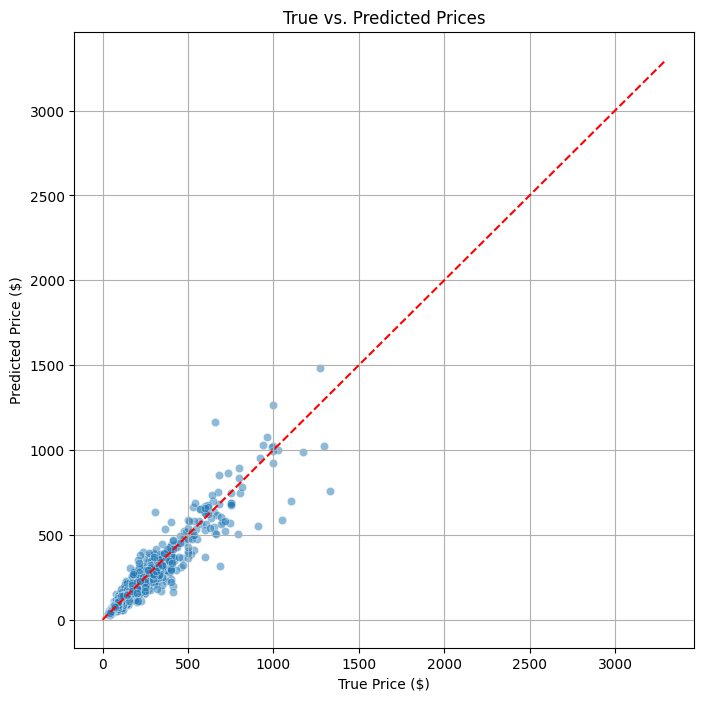

/tmp/ipython-input-3368184539.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='price_bin', y='mape', data=binned_mape, palette='viridis'); plt.title("MAPE by Price Bracket")


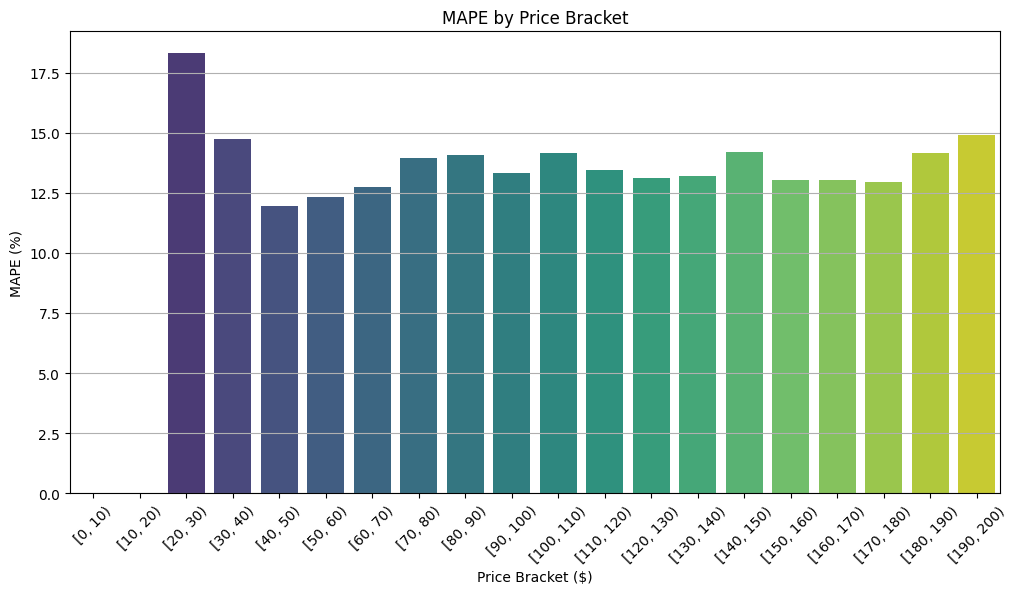


--- Analysis of Multiplicative Decomposition ---
Average Additive Contribution of Each Component to the Log-Price Deviation:
p_location         0.185493
p_seasonality      0.081491
p_size_capacity   -0.021540
p_amenities       -0.040241
p_quality         -0.150698
p_description     -0.233258
dtype: float32


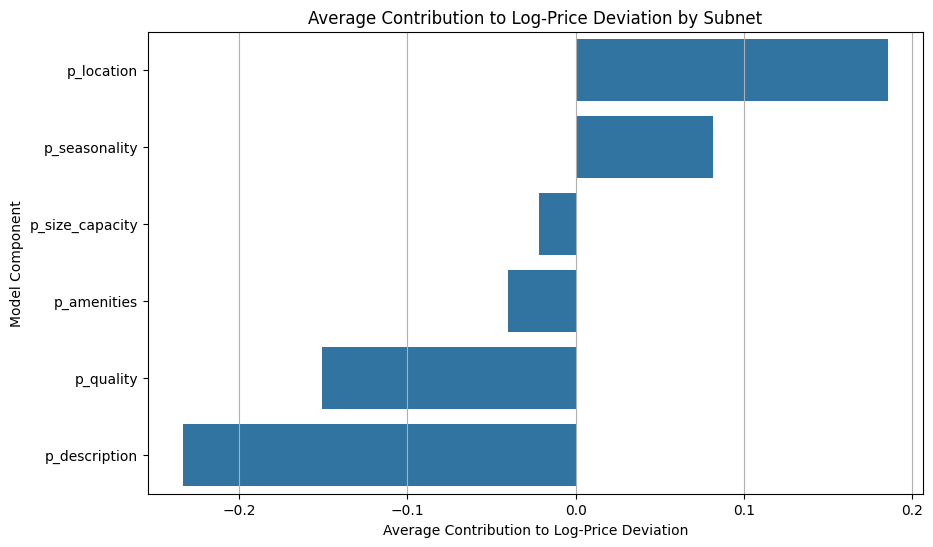

In [14]:
# --- Run Full Experiment ---
set_seed(config['SEED'])
artifacts = main(config)

In [34]:
# --- Post-Training Step: Prepare the full dataset for search ---

print("Preparing the full dataset for the nearest neighbor application...")

train_df, val_df, neighborhood_log_means = load_and_split_data(config)

# 1. Load the trained model and processor from artifacts
trained_model = artifacts['model']
processor = artifacts['processor']
config = artifacts['config']

# 2. Create a DataLoader for the TRAINING set for inference (no shuffling)
# (Assumes 'train_df' and 'neighborhood_log_means' are in the environment)
train_features = processor.transform(train_df, neighborhood_log_means)
train_loader_for_inference = DataLoader(
    AirbnbPriceDataset(train_features, AutoTokenizer.from_pretrained(config['TEXT_MODEL_NAME'])),
    batch_size=config['VALIDATION_BATCH_SIZE'], # Use larger batch size for faster inference
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# 3. Run inference on the TRAINING set to get its hidden states and contributions
print("\nRunning inference on the training set...")
train_details_outputs = run_inference_with_details(trained_model, train_loader_for_inference, config['DEVICE'])

# 4. Create a detailed DataFrame for the TRAINING set
train_df_with_details = train_df.copy()
for key, value in train_details_outputs.items():
    train_df_with_details[key] = list(value)

# 5. Get the detailed DataFrame for the VALIDATION set from artifacts
val_df_with_details = artifacts['val_df_with_details']

# 6. Concatenate the training and validation data into one complete DataFrame
print("\nCombining training and validation sets into a single search database.")
full_dataset_with_details = pd.concat([train_df_with_details, val_df_with_details], ignore_index=True)

print(f"Full dataset prepared with {len(full_dataset_with_details):,} total listings.")

Preparing the full dataset for the nearest neighbor application...
Loading dataset from: ./nyc_dataset_oct_20.parquet
Split complete. Training: 98,388, Validation: 24,598


/tmp/ipython-input-3102782108.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['neighborhood_log_mean'].fillna(global_mean, inplace=True)



Running inference on the training set...


Running Inference with Details:   0%|          | 0/193 [00:00<?, ?it/s]


Combining training and validation sets into a single search database.
Full dataset prepared with 122,986 total listings.


### **9. Setup for Nearest Neighbor Search**

This cell prepares the necessary data for the similarity search. It extracts the hidden state vectors, price contributions, and key listing features (including latitude and longitude) from the validation set results. These are converted into efficient NumPy arrays for fast computation.

In [35]:
from scipy.spatial.distance import cdist
from IPython.display import display

# --- Use the FULL combined dataset for the search application ---
search_df = full_dataset_with_details
print(f"Preparing data for {len(search_df):,} listings from the full dataset...")

# --- Prepare Hidden States (The "What") ---
hidden_states = {col.replace('h_', ''): np.stack(search_df[col].values)
                 for col in search_df.columns if col.startswith('h_')}
print(f"\nPrepared hidden state matrices for axes: {list(hidden_states.keys())}")

# --- Prepare Price Contributions (The "Why") ---
price_contributions = {col.replace('p_', ''): search_df[col].to_numpy()
                       for col in search_df.columns if col.startswith('p_')}
print(f"Prepared price contribution vectors for axes: {list(price_contributions.keys())}")

# --- Prepare Geospatial and Listing Info ---
base_cols = ['id', 'price', 'predicted_price', 'neighbourhood_cleansed',
             'property_type', 'room_type', 'accommodates', 'bedrooms',
             'latitude', 'longitude']
p_cols = [col for col in search_df.columns if col.startswith('p_')]

listing_info = search_df[base_cols + p_cols]
listing_ids = listing_info['id'].to_numpy()
lat_lon_rad = np.deg2rad(listing_info[['latitude', 'longitude']].to_numpy())

Preparing data for 122,986 listings from the full dataset...

Prepared hidden state matrices for axes: ['location', 'size_capacity', 'quality', 'amenities', 'description', 'seasonality']
Prepared price contribution vectors for axes: ['location', 'size_capacity', 'quality', 'amenities', 'description', 'seasonality']


### **10. Helper Functions: Distances and Axis-Importance**

This cell defines the core utility functions for the search algorithm. It includes a function for calculating Haversine distance (for geospatial filtering), functions for computing vector distances (Euclidean and Cosine), and a function to calculate the personalized axis-importance weights for a given listing, which now supports excluding certain axes from the calculation.

In [36]:
def haversine_distance(latlon1_rad, latlon2_rad):
    """Calculates the Haversine distance between one or more points in radians."""
    dlon = latlon2_rad[:, 1] - latlon1_rad[1]
    dlat = latlon2_rad[:, 0] - latlon1_rad[0]
    a = np.sin(dlat / 2.0)**2 + np.cos(latlon1_rad[0]) * np.cos(latlon2_rad[:, 0]) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 3959 * c # Earth radius in miles

def calculate_axis_importances(p_contributions_single_listing: dict, exclude_axes: list = None) -> dict:
    """
    Calculates the normalized weights for each axis based on the absolute
    magnitude of its price contribution, excluding specified axes.
    """
    exclude_axes = exclude_axes or []
    filtered_contributions = {k: v for k, v in p_contributions_single_listing.items() if k not in exclude_axes}

    abs_contributions = {k: abs(v) for k, v in filtered_contributions.items()}
    total_abs_contribution = sum(abs_contributions.values())

    if total_abs_contribution == 0:
        return {k: 1.0 / len(abs_contributions) for k in abs_contributions}

    return {k: v / total_abs_contribution for k, v in abs_contributions.items()}

def euclidean_distance(vector, matrix):
    """Calculates the Euclidean distance from a vector to all rows in a matrix."""
    return cdist(vector.reshape(1, -1), matrix, 'euclidean').flatten()

def cosine_distance(vector, matrix):
    """Calculates the Cosine distance from a vector to all rows in a matrix."""
    return cdist(vector.reshape(1, -1), matrix, 'cosine').flatten()

### **11. The Nearest Neighbor Search Function**

This is the main search function. It first identifies a candidate pool of listings within a 2-mile radius of the query listing. Then, it calculates a weighted similarity score across all other feature axes (e.g., quality, size, description) to find the most relevantly similar listings within that geographic area.

In [37]:
def find_nearest_neighbors(query_idx: int, top_k: int = 5, radius_miles: float = 2.0):
    """
    Finds the top K nearest neighbors for a listing within a geographic radius,
    explicitly excluding other instances of the same listing (e.g., from
    different months).
    """
    # 1. Geospatial Filtering: Create the initial candidate pool
    query_lat_lon_rad = lat_lon_rad[query_idx]
    distances_miles = haversine_distance(query_lat_lon_rad, lat_lon_rad)
    candidate_indices = np.where((distances_miles > 0) & (distances_miles <= radius_miles))[0]

    # --- NEW: Filter out listings with the same ID as the query ---
    query_id = listing_ids[query_idx]
    candidate_ids = listing_ids[candidate_indices]
    mask = (candidate_ids != query_id)
    candidate_indices = candidate_indices[mask]
    # --- End of new filtering logic ---

    if len(candidate_indices) < top_k:
        print(f"Warning: Found only {len(candidate_indices)} unique candidates within {radius_miles} miles.")
        top_k = len(candidate_indices)
        if top_k == 0: return [], {}

    # 2. Calculate Axis-Importance Weights (excluding location)
    query_contributions = {name: p_vec[query_idx] for name, p_vec in price_contributions.items()}
    weights = calculate_axis_importances(query_contributions, exclude_axes=['location'])

    # 3. Calculate and combine weighted distances for the filtered candidates
    final_scores = np.zeros(len(candidate_indices))
    search_axes = [axis for axis in hidden_states.keys() if axis != 'location']

    for axis in search_axes:
        h_matrix = hidden_states[axis]
        query_h_vector = h_matrix[query_idx]
        candidate_h_matrix = h_matrix[candidate_indices]

        dist_func = cosine_distance if axis in ["amenities", "description"] else euclidean_distance
        raw_dists = dist_func(query_h_vector, candidate_h_matrix)

        min_dist, max_dist = raw_dists.min(), raw_dists.max()
        normalized_dists = (raw_dists - min_dist) / (max_dist - min_dist) if max_dist > min_dist else np.zeros_like(raw_dists)
        final_scores += weights.get(axis, 0) * normalized_dists

    # 4. Find and return the top_k results
    nearest_candidate_indices = np.argsort(final_scores)
    nearest_original_indices = candidate_indices[nearest_candidate_indices]
    return nearest_original_indices[:top_k], weights

### **12. Demonstration and Results Visualization**

This final cell runs the nearest neighbor search for several random listings and displays the results. The output includes the personalized axis-importance weights used for the search and a detailed, side-by-side comparison table showing the features and price decomposition of the query listing and its closest neighbors.

In [43]:
def display_neighbor_results(query_idx, neighbor_indices, weights, df_with_details):
    """Formats and displays the nearest neighbor results in a comparison table."""
    print("\n" + "="*80 + f"\nFinding Nearest Neighbors for Listing #{query_idx}\n" + "="*80)

    print("Personalized Axis Importances for Search (Location Excluded):")
    sorted_weights = sorted(weights.items(), key=lambda item: item[1], reverse=True)
    for axis, weight in sorted_weights:
        print(f"  - {axis:<15}: {weight:.2%}")

    # --- Prepare the Comparison DataFrame ---
    all_indices = [query_idx] + list(neighbor_indices)
    feature_cols = ['price', 'predicted_price', 'neighbourhood_cleansed',
                    'room_type', 'accommodates', 'bedrooms']
    p_cols = [f'p_{name}' for name in price_contributions.keys()]

    full_p_cols_df = df_with_details[[col for col in df_with_details.columns if col.startswith('p_')]]
    comparison_df = df_with_details.loc[all_indices, feature_cols].copy()
    comparison_df = pd.concat([comparison_df, full_p_cols_df.loc[all_indices]], axis=1)

    listing_labels = ['Query'] + [f'Neighbor {i+1}' for i in range(len(neighbor_indices))]
    comparison_df.insert(0, 'Listing', listing_labels)
    comparison_df = comparison_df.set_index('Listing')

    # --- Style the DataFrame for better readability ---
    float_format = {'price': "${:.2f}", 'predicted_price': "${:.2f}"}
    for col in p_cols: float_format[col] = "{:.3f}"

    styled_df = comparison_df.style \
        .format(float_format) \
        .background_gradient(cmap='RdYlGn', subset=p_cols, axis=1, vmin=-0.5, vmax=0.5) \
        .set_table_styles([{'selector': 'th.row_heading.level0', 'props': [('font-weight', 'bold') if i == 'Query' else ('font-weight', 'normal') for i in comparison_df.index]}])

    print("\n--- Side-by-Side Comparison ---")
    display(styled_df)

In [45]:
for i in range(3):
    random_idx = np.random.randint(0, len(listing_info))
    neighbor_indices, weights = find_nearest_neighbors(random_idx, top_k=5)
    if neighbor_indices is not None and len(neighbor_indices) > 0:
        # CORRECTED LINE: Pass 'search_df' which is the full dataset, matching the indices.
        display_neighbor_results(random_idx, neighbor_indices, weights, search_df)


Finding Nearest Neighbors for Listing #115637
Personalized Axis Importances for Search (Location Excluded):
  - quality        : 42.37%
  - amenities      : 26.76%
  - description    : 20.12%
  - size_capacity  : 5.55%
  - seasonality    : 5.20%

--- Side-by-Side Comparison ---


,price,predicted_price,neighbourhood_cleansed,room_type,accommodates,bedrooms,p_location,p_size_capacity,p_quality,p_amenities,p_description,p_seasonality
Listing,,,,,,,,,,,,
Query,$215.00,$220.41,Fort Greene,Entire home/apt,3,1,0.061,0.028,-0.217,0.137,0.103,0.027
Neighbor 1,$199.00,$205.88,Williamsburg,Entire home/apt,2,1,0.147,-0.045,-0.211,0.162,-0.045,0.027
Neighbor 2,$199.00,$199.40,Williamsburg,Entire home/apt,2,1,0.147,-0.045,-0.215,0.162,-0.045,-0.001
Neighbor 3,$250.00,$220.90,Williamsburg,Entire home/apt,2,1,0.147,-0.045,-0.211,0.162,-0.045,0.097
Neighbor 4,$819.00,$731.46,Carroll Gardens,Entire home/apt,6,3,-0.056,0.678,-0.181,0.208,0.182,0.027
Neighbor 5,$181.00,$158.25,Bedford-Stuyvesant,Private room,2,1,0.169,-0.228,-0.282,0.065,0.194,0.027



Finding Nearest Neighbors for Listing #75614
Personalized Axis Importances for Search (Location Excluded):
  - size_capacity  : 31.70%
  - description    : 30.07%
  - quality        : 18.29%
  - amenities      : 10.72%
  - seasonality    : 9.22%

--- Side-by-Side Comparison ---


,price,predicted_price,neighbourhood_cleansed,room_type,accommodates,bedrooms,p_location,p_size_capacity,p_quality,p_amenities,p_description,p_seasonality
Listing,,,,,,,,,,,,
Query,$165.00,$182.88,Williamsburg,Entire home/apt,5,2,0.180,0.459,-0.265,-0.155,-0.435,0.133
Neighbor 1,$220.00,$188.84,Williamsburg,Entire home/apt,4,2,0.231,0.207,-0.109,-0.135,-0.379,0.133
Neighbor 2,$291.00,$295.55,Williamsburg,Entire home/apt,6,2,0.140,0.513,-0.066,-0.025,-0.300,0.133
Neighbor 3,$500.00,$370.47,East Village,Entire home/apt,6,3,0.191,0.706,-0.190,0.035,-0.373,0.133
Neighbor 4,$150.00,$143.14,Bedford-Stuyvesant,Entire home/apt,3,2,0.125,0.123,-0.165,-0.126,-0.246,0.133
Neighbor 5,$150.00,$169.54,Greenpoint,Entire home/apt,5,3,0.035,0.418,-0.197,-0.018,-0.752,0.133



Finding Nearest Neighbors for Listing #7038
Personalized Axis Importances for Search (Location Excluded):
  - size_capacity  : 31.42%
  - description    : 28.70%
  - quality        : 16.56%
  - amenities      : 12.67%
  - seasonality    : 10.65%

--- Side-by-Side Comparison ---


,price,predicted_price,neighbourhood_cleansed,room_type,accommodates,bedrooms,p_location,p_size_capacity,p_quality,p_amenities,p_description,p_seasonality
Listing,,,,,,,,,,,,
Query,$58.00,$57.92,Morris Park,Private room,2,1,0.560,-0.276,-0.146,-0.111,-0.252,0.094
Neighbor 1,$70.00,$59.16,Morris Park,Private room,2,1,0.544,-0.276,-0.073,-0.119,-0.279,0.094
Neighbor 2,$70.00,$60.68,Morris Park,Private room,2,1,0.544,-0.276,-0.073,-0.119,-0.279,0.119
Neighbor 3,$63.00,$64.03,Morris Park,Private room,2,1,0.547,-0.276,-0.093,-0.098,-0.206,0.094
Neighbor 4,$70.00,$60.60,Morris Park,Private room,2,1,0.544,-0.276,-0.073,-0.119,-0.279,0.117
Neighbor 5,$50.00,$50.61,Bronxdale,Private room,2,1,0.523,-0.276,-0.095,-0.207,-0.197,0.094
